# Advanced Bayesian statistical modeling

The goal of this assignment is to perform Bayesian inference on various advanced statistical models in R.

## Problem #1 Analysis of a bioassay experiment

[(Modified from *Bayesian Data Analysis, 3rd Edition*)](https://avehtari.github.io/BDA_R_demos/demos_ch3/demo3_6.html)

Here is an example of a nonconjugate model for a bioassay experiment, drawn from the literature on applied Bayesian statistics. "Bioassay" is the measurement of the concentration or potency of a substance by its effect on living cells or tissues.

In the development of drugs and other chemical compounds, acute toxicity tests or bioassay experiments are commonly performed on animals. Such experiments proceed by administering various dose levels of the compound to batches of animals. The animals’ responses are typically characterized by a dichotomous outcome: for example, alive or dead, tumor or no tumor. An experiment of this kind gives rise to data of the form

- $x_i$: the $i^{th}$ of $k$ dose levels (log scale), $i = 1,...,k$

- $n_i$: the number of animals that were given the $i^{th}$ dose level

- $y_i$: the number of animals out of $n_i$ that responded to the dose positively


In [9]:
library(ggplot2)
library(gridExtra)
library(tidyr)
library(dplyr)
library(purrr)

df = data.frame(
  x = c(-0.86, -0.30, -0.05, 0.73),
  n = c(5, 5, 5, 5),
  y = c(0, 1, 3, 5)
)

df

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



x,n,y
-0.86,5,0
-0.30,5,1
-0.05,5,3
0.73,5,5


We assume that $Y_i \, | \, p_i \sim Bin(n_i,p_i)$, where $p_i$ is the probability that an animal within group $i$ responds positively. Importantly, we are assuming that the probability of a positive response within the $i^{th}$ group is stable across animals. However, we cannot assume that the probability of a positive response is stable across dose groups, because the probability of the outcome is thought to be impacted by the dose amount. So, $p_i \ne p_j$ for $i\ne j \in \{1,...,k\}$. We assume instead that $p_i$ is a function of dose, $x_i$:

\begin{align*}
\text{logit}(p_i) = \log\left(\frac{p_i}{1-p_i} \right) = \beta_0 + \beta_1 x_i,
\end{align*}

which implies that 

\begin{align*}
\text{logit}^{−1}(\beta_0 + \beta_1x_i) = p_i = \frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}.
\end{align*}



Note that the log-likelihood function is given by 

\begin{align*}
\ell(\boldsymbol\beta) \propto \sum y_i\eta_i - \sum n_i\log\left(1 + e^{\eta_i} \right)
\end{align*}

**1.(a) Below, we first write a function to calculate the log-likelihood given a dataframe with $\mathbf{x}, \mathbf{y}$, and $\mathbf{n}$ and evaluation points `b0` and `b1`. Then, we sum over $i = 1,...,k$ and exponentiate.**

In [10]:
logpost = function(beta, df){
    b0 = beta[1]; b1 = beta[2]
    x = df[,1]; n = df[,2]; y = df[,3]
    eta = b0 + b1*x
    logpost = sum(y*eta - n*log(1+exp(eta)))
    return(logpost)
}

We place a uniform prior distribution over $\beta_0$ and $\beta_1$ (instead of a prior on $p_i$):  

$$\beta_0 \sim U(-5,10), \,\,\,\, \beta_1 \sim U(-10, 40).$$

The likelihood function above is our posterior distribution, up to a constant, since we have a constant prior.

**1.(b) Write an algorithm to sample from the posterior distribution of $\beta_0$ and $\beta_1$ given the data. Show evidence of convergence.**

Note that I have several cells below because in the solution file, I write out the MH algorithm in one cell, plots in another, then I use a built-in R function for adaptive MH for comparison. You don't have to run MCMC twice.

In [14]:
set.seed(9181)

mhs = function(beta){  
    library(mvtnorm)
    proposal_sd = c(10,10)
    samples = matrix(NA,T,2)
    for (t in 1:T){  
        proposal = rmvnorm(1,beta,diag(proposal_sd)); #sample a proposal
        logR = logpost(proposal, df) - 
            logpost(beta,df); #compute the log of the ratio
        if(log(runif(1))<logR){
            beta = proposal #accept/reject the proposal
            }
            samples[t,] = beta #store the accept/reject in the chain
        }
    return(samples)
}

T = 50000
mychain = mhs(c(1,1))


[1]  1.282959 11.449933

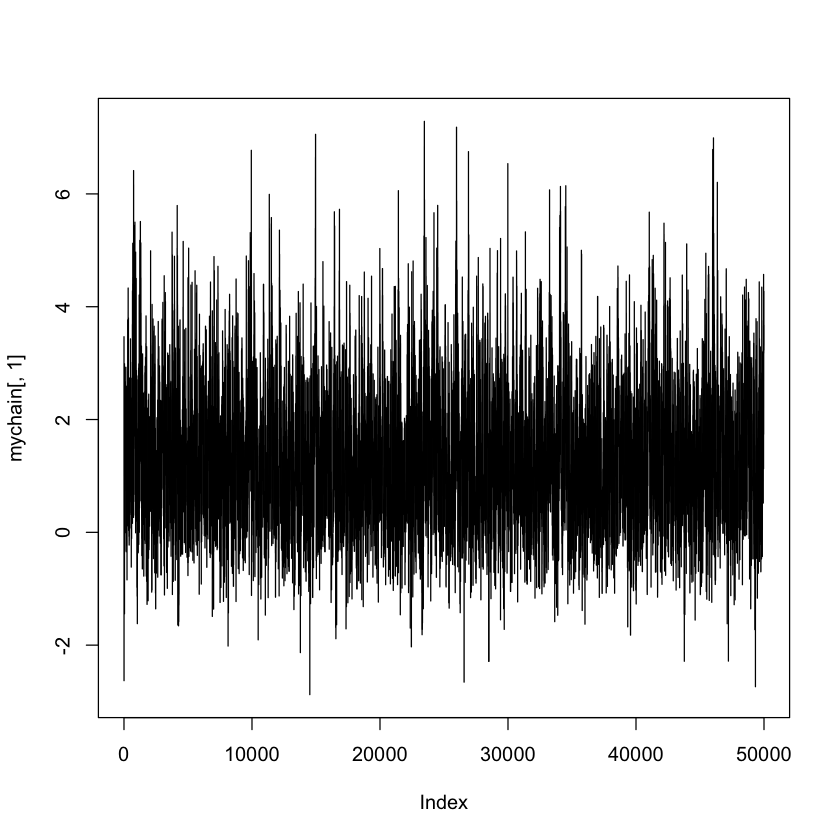

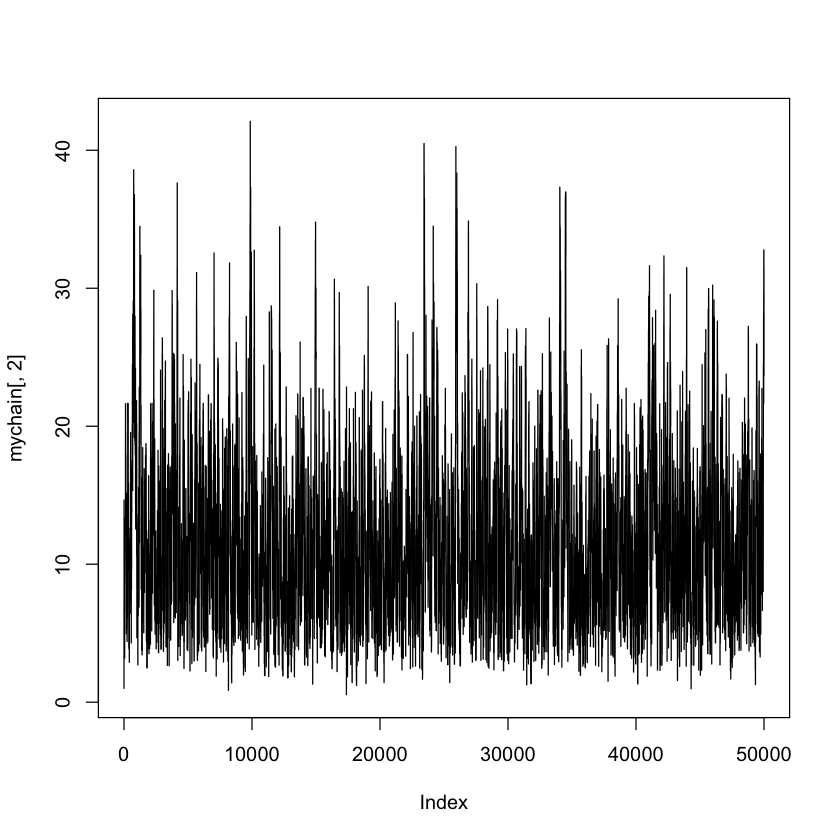

In [15]:
colMeans(mychain)
plot(mychain[,1],type = "l")
plot(mychain[,2],type = "l")

In [16]:
library(MHadaptive)
set.seed(9181)
# Initial values
beta = c(1,1)
can_sd = c(1,1)
T = 50000
adapt = Metro_Hastings(logpost, beta, prop_sigma = NULL,
        par_names = NULL, iterations = T, burn_in = 1000,
        adapt_par = c(100, 20, 0.5, 0.75), quiet = FALSE, df = df)

[1] "updating: 10%"
[1] "updating: 20%"
[1] "updating: 30%"
[1] "updating: 40%"
[1] "updating: 50%"
[1] "updating: 60%"
[1] "updating: 70%"
[1] "updating: 80%"
[1] "updating: 90%"
[1] "updating: 100%"


[1]  1.338673 11.637168

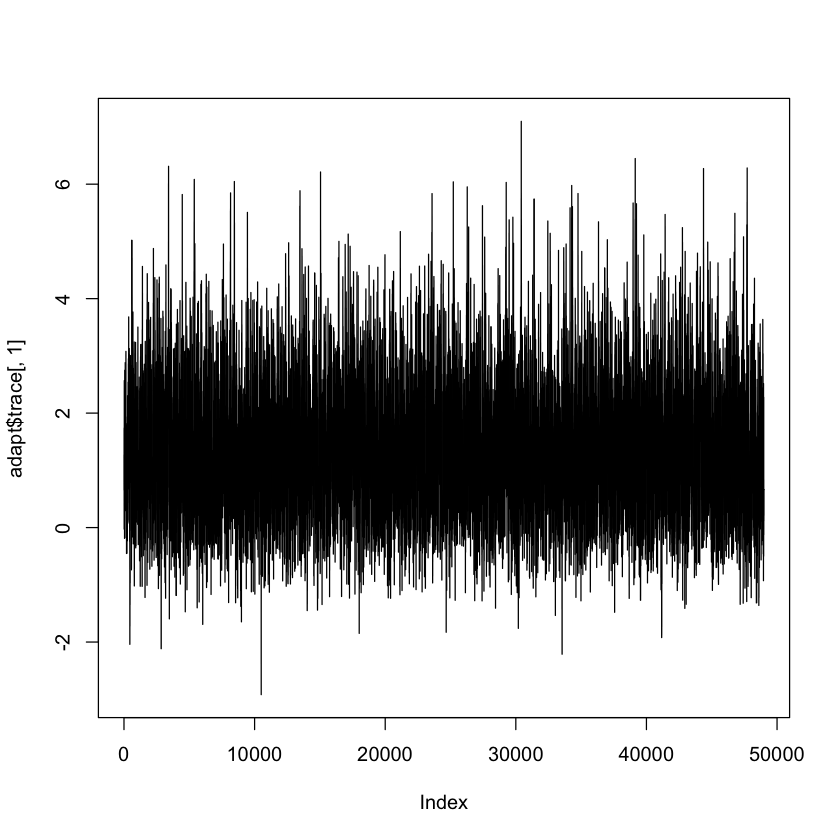

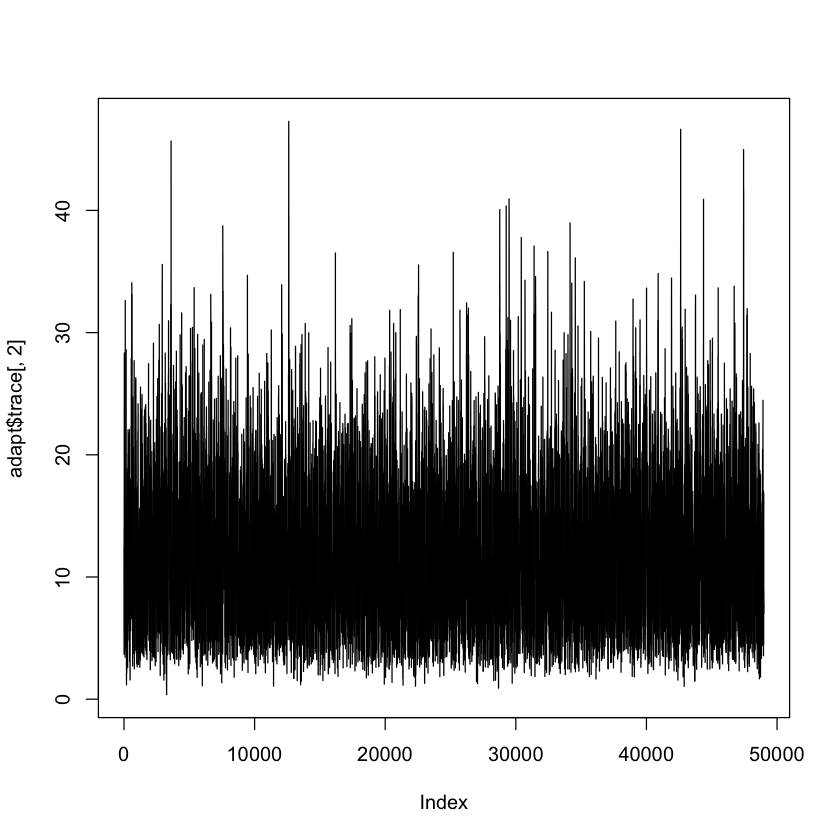

In [17]:
colMeans(adapt$trace)
plot(adapt$trace[,1],type = "l")
plot(adapt$trace[,2],type = "l")

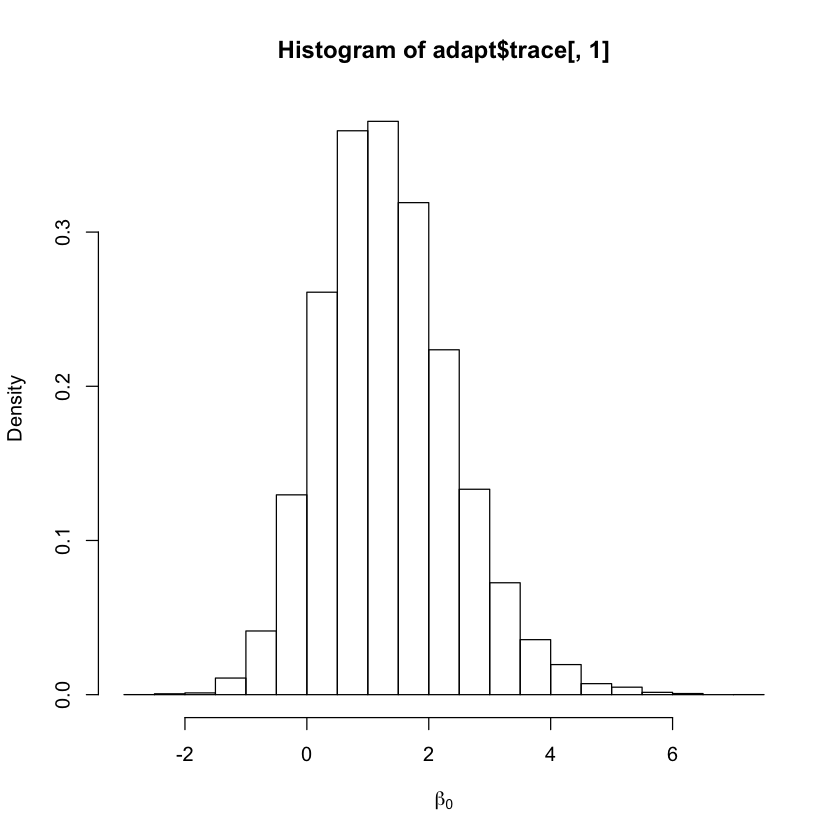

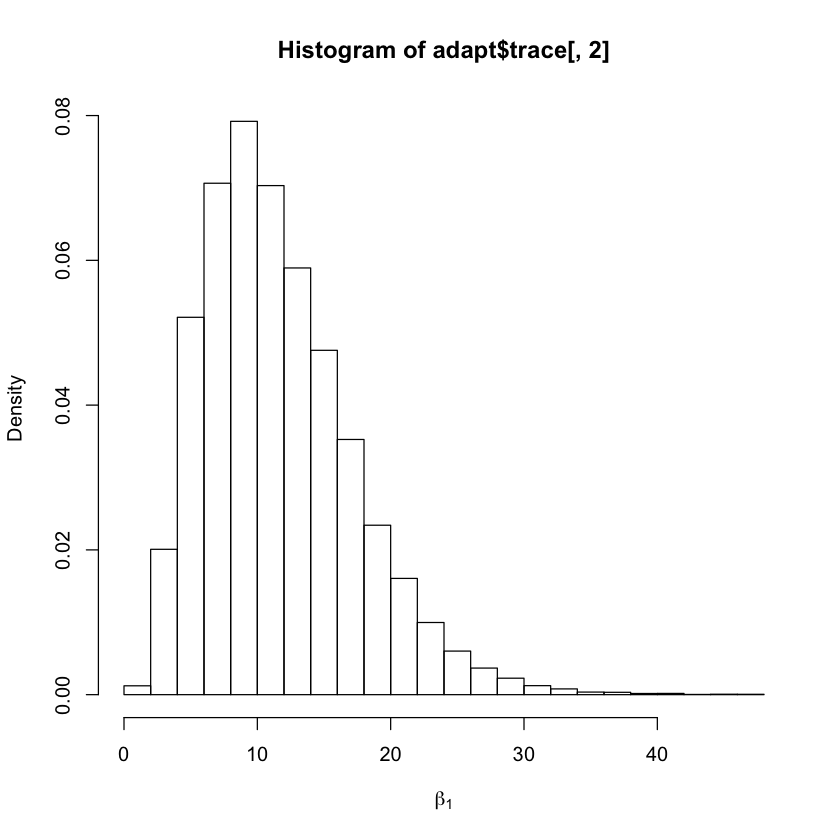

In [30]:
hist(adapt$trace[,1], xlab = expression(beta[0]), prob = TRUE)
hist(adapt$trace[,2], xlab = expression(beta[1]), prob = TRUE)

In [31]:
#glmod_bin = glm(cbind(y,n-y) ~ x, data = df, family = binomial)
#summary(glmod_bin)

**1.(c) Estimate the posterior predictive distribution for $x = 0.5$.**

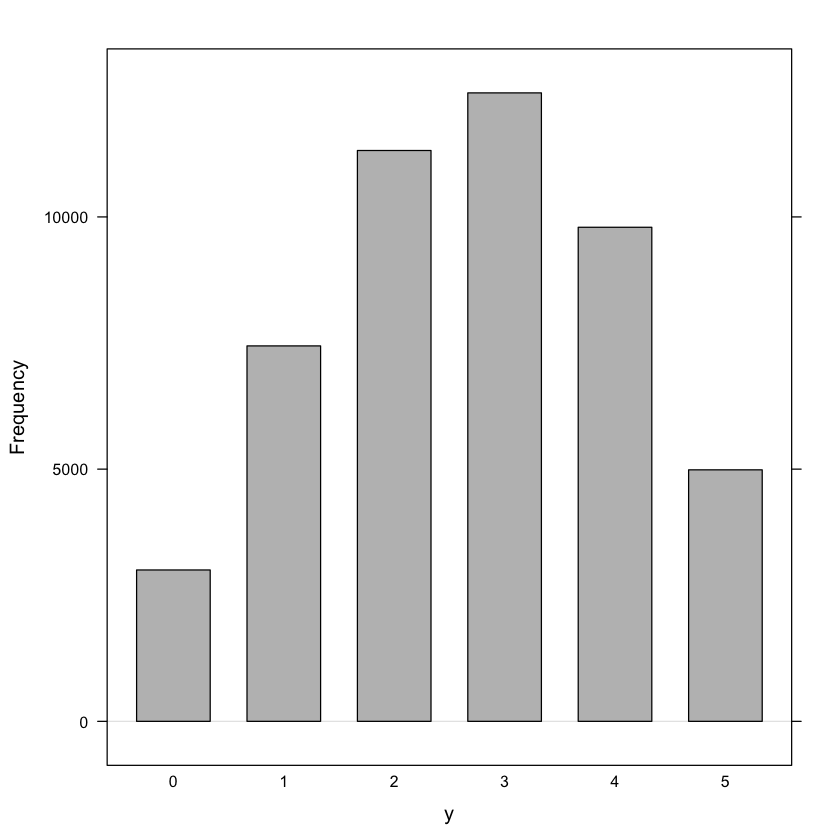

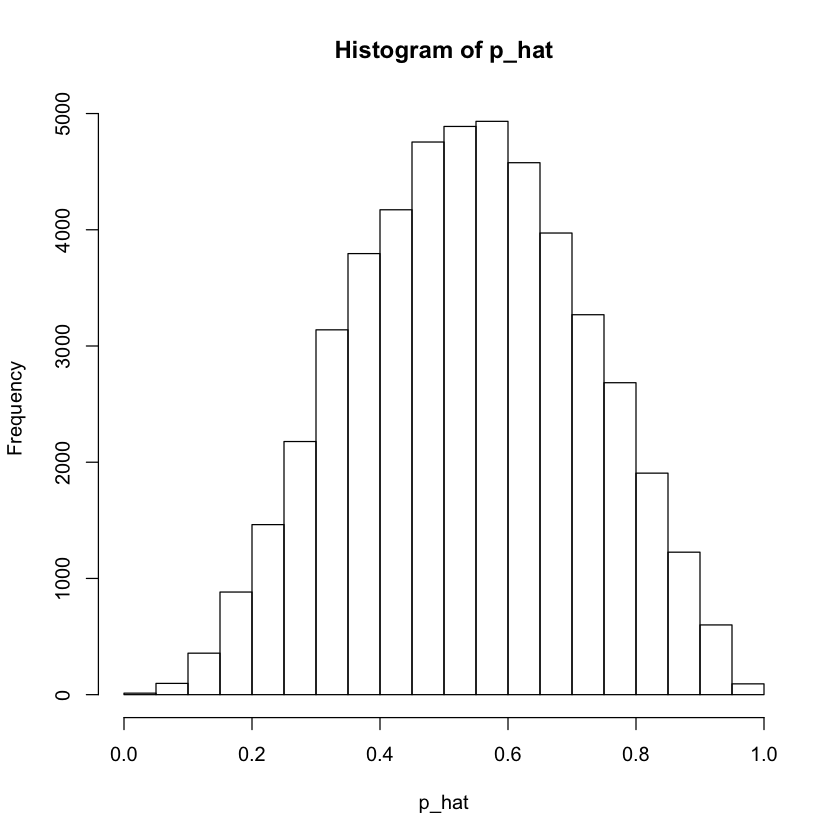

In [36]:
x = -0.1 #value of x at which to make at prediction  
beta_mcmc = adapt$trace

T = dim(beta_mcmc)[1]; 

p_hat = rep(0,T)
y_hat = rep(0,T)
for (t in 1:T){
    eta = beta_mcmc[t,1] + beta_mcmc[t,2]*x #=log odds 
    exp(eta) #odds
    p_hat[t] = exp(eta)/(1 + exp(eta)); 
    y_hat[t] = rbinom(1,5,p_hat[t])
}

library(lattice)
barchart(as.factor(y_hat),horizontal = FALSE, #Turn the bars so they are vertical
         xlab = "y", #Label the x axis
         ylab = "Frequency", #Label the y axis 
         col = "grey")
hist(p_hat)

## Problem #2 Poisson regression

For each 30 Galapagos islands, we have a count of the number of plant species found on each island and the number that are endemic to that island. We also have five geographic variables for each island. 

1. Species: the number of plant species found on the island
2. Endemics: the number of endemic species
3. Area: the area of the island (km$^2$)
4. Elevation: the highest elevation of the island (m)
5. Nearest: the distance from the nearest island (km)
6. Scruz: the distance from Santa Cruz island (km)
7. Adjacent: the area of the adjacent island (square km)

**2.(a) Remove the Endemics variable from the dataframe, and fit a Poisson regression (generlized linear model) with Species as the response and all other variables as predictors. Run some diagnostics and explain why this model is not the best fit.**

In [36]:
library(ggplot2)
gala = read.table("https://www.colorado.edu/amath/sites/default/files/attached-files/gala.txt", header = TRUE, sep = "\t")
gala = gala[,-2]

head(gala)
dim(gala)

,Species,Area,Elevation,Nearest,Scruz,Adjacent
Baltra,58,25.09,346,0.6,0.6,1.84
Bartolome,31,1.24,109,0.6,26.3,572.33
Caldwell,3,0.21,114,2.8,58.7,0.78
Champion,25,0.10,46,1.9,47.4,0.18
Coamano,2,0.05,77,1.9,1.9,903.82
Daphne.Major,18,0.34,119,8.0,8.0,1.84


[1] 30  6


Call:
glm(formula = Species ~ ., family = poisson, data = gala)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.2752  -4.4966  -0.9443   1.9168  10.1849  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.155e+00  5.175e-02  60.963  < 2e-16 ***
Area        -5.799e-04  2.627e-05 -22.074  < 2e-16 ***
Elevation    3.541e-03  8.741e-05  40.507  < 2e-16 ***
Nearest      8.826e-03  1.821e-03   4.846 1.26e-06 ***
Scruz       -5.709e-03  6.256e-04  -9.126  < 2e-16 ***
Adjacent    -6.630e-04  2.933e-05 -22.608  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 3510.73  on 29  degrees of freedom
Residual deviance:  716.85  on 24  degrees of freedom
AIC: 889.68

Number of Fisher Scoring iterations: 5


Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”

ERROR: Error in stdres(glmod): could not find function "stdres"


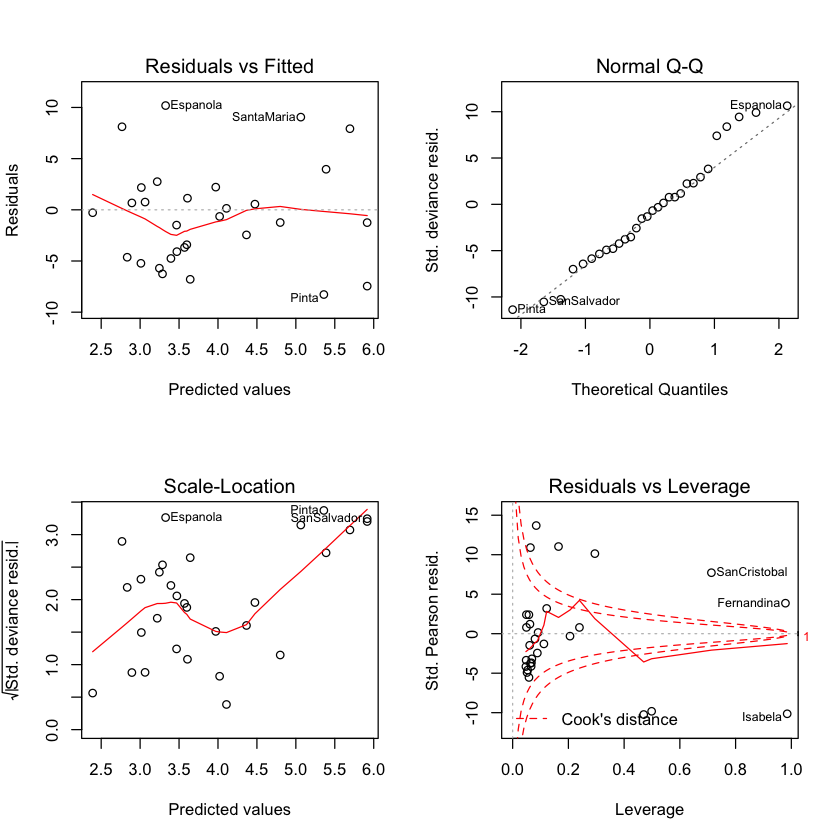

In [37]:
glmod = glm(Species ~ ., data = gala, family = poisson)
summary(glmod)
par(mfrow = c(2,2)); plot(glmod)

df = data.frame(x = predict(glmod, type = "link"), y = stdres(glmod))
ggplot(df, aes(x = x, y = y)) + 
    geom_point() + 
    theme_bw() + 
    geom_hline(yintercept = 0)


**2.(b)  Fit a Bayesian Poisson regression! In particular:**

1. Let $\beta_j \overset{iid}{\sim}N(0,1)$


2. Write three functions:

    1. one that computes the log-prior on $\boldsymbol\beta$; 
    2. one that takes in the centered/scaled predictors (leave the response in the original units) and computes the Poisson regression log-likelihood; and 
    3. one that makes use of the log-prior and log-likelihood to compute the log-posterior (up to a constant). 


3. Perform adaptive Metropoli-Hastings to estimate the posterior of $\boldsymbol\beta \, | \, \mathbf{y}$. Start  beta at `beta = rep(0,6)`. Run the chain for `T = 50,000` iterations with a burn-in of `10,000`.

In [44]:
loglike_poisson = function(beta, data){
    y = data[,1]; X = as.matrix(cbind(1,data[,-1])); #assumes response is first column
    eta = X%*%beta #includes intercept
    logplike = -sum(exp(eta)) + sum(y*eta)
    return(logplike)
}

prior_poisson = function(beta,mu0,sig0){
    prior = 0
    for (i in 1:length(beta)){
        prior = prior + dnorm(beta[i], mu0[i],sig0[i],log = TRUE)
    }
    return(prior)
}

logpost_poisson = function(beta,data,mu0,sig0){
    #y = data[,1]; X = as.matrix(cbind(1,data[,-1])); #X = as.matrix(cbind(1,data[,-1])); #assumes response is first column SCALE PREDICTORS
    #eta = X%*%beta #includes intercept
    logpost = loglike_poisson(beta,data) + prior_poisson(beta,mu0,sig0)
    return(logpost)
}




In [46]:
library(MHadaptive)

mu0 = rep(0,6); sig0 = rep(1,6); 
beta = rep(0,6)
T = 50000
burnin = 1
adapt = Metro_Hastings(logpost_poisson, beta, prop_sigma = NULL,
        par_names = NULL, iterations = T, burn_in = burnin, 
                       adapt_par = c(100, 20, 0.5, 0.75), quiet = FALSE, 
                       data = gala, mu0 = mu0, sig0 = sig0)

[1] "updating: 10%"
[1] "updating: 20%"
[1] "updating: 30%"
[1] "updating: 40%"
[1] "updating: 50%"
[1] "updating: 60%"
[1] "updating: 70%"
[1] "updating: 80%"
[1] "updating: 90%"
[1] "updating: 100%"


**2.(c) Consider some diagnostics to check convergence.**

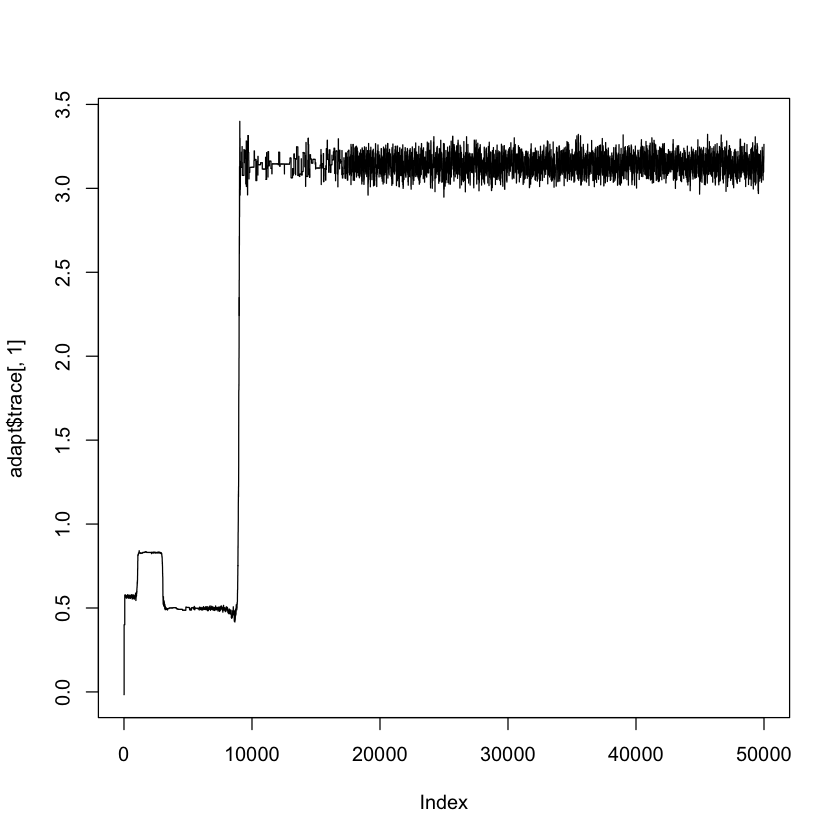

[1] 0.2155843

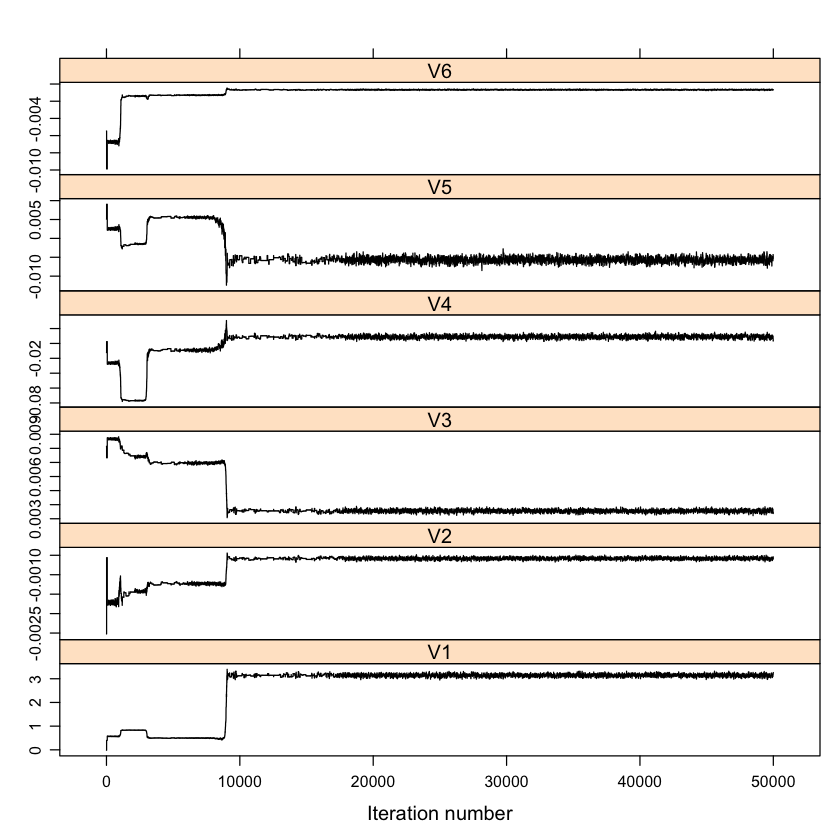

In [47]:
library(coda)
library(lattice)
plot(adapt$trace[,1], type = "l")
#plot(adapt$trace[,2], type = "l")
xyplot(mcmc(adapt$trace),col="black") #in lattice

adapt$accept

**2.(d) Compute the mean of the stationary distribution of the chains. Compare them with the frequentist GLM from part (a).**

In [48]:
colMeans(adapt$trace[-(1:20000),])
coef(glmod)

[1]  3.1445969268 -0.0005823015  0.0035528760  0.0088476129 -0.0056871637
[6] -0.0006656103

(Intercept)          Area     Elevation       Nearest         Scruz 
 3.1548078779 -0.0005799429  0.0035405940  0.0088255719 -0.0057094223 
     Adjacent 
-0.0006630311

Note that the `arm` package has a function `bayesianglm()` that fits a Bayesian Poisson regression.

In [95]:
library(arm)
M1 = bayesglm(Species ~ ., data = gala, family=poisson, prior.scale=10, prior.df=20)
#summary(M1)


Call:
bayesglm(formula = Species ~ ., family = poisson, data = gala, 
    prior.scale = 10, prior.df = 20)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.2743  -4.4967  -0.9441   1.9167  10.1849  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.155e+00  5.175e-02  60.965  < 2e-16 ***
Area        -5.799e-04  2.627e-05 -22.072  < 2e-16 ***
Elevation    3.540e-03  8.740e-05  40.507  < 2e-16 ***
Nearest      8.826e-03  1.821e-03   4.846 1.26e-06 ***
Scruz       -5.709e-03  6.256e-04  -9.126  < 2e-16 ***
Adjacent    -6.630e-04  2.933e-05 -22.607  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 3510.73  on 29  degrees of freedom
Residual deviance:  716.85  on 24  degrees of freedom
AIC: 889.68

Number of Fisher Scoring iterations: 5


**2.(e) Interpret the parameter associated with Nearest.**

In [17]:
exp(8.826e-03)

[1] 1.008865


If the model is correct, a one unit increase in nearest is associated with a multiplicitive increase of $\exp(8.826\times 10^{-3}) = 1.01$ in species, on average, adjusting for other predictors.